In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


from sklearn.model_selection import train_test_split

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white, het_breuschpagan, het_goldfeldquandt, linear_reset
import geopandas as gpd
from fiona.drvsupport import supported_drivers

In [220]:
from statsmodels.stats.outliers_influence import reset_ramsey

In [2]:
supported_drivers['KML'] = 'rw'

dubai_area_coordinates = gpd.read_file('Community.kml', driver='KML')

In [3]:
df = pd.read_csv('transactions-2023-01-11.csv')

In [4]:
def drop_excess_columns(data):
    # Drop high cardinality columns
    data = data.drop(columns=["Transaction Number", "Property ID", "Transaction Size (sq.m)", "Parking", "Project"])
    # Drop low-cardinality columns
    data = data.drop(columns=["Master Project"])
#     data = data.drop(columns=["Registration type", "Is Free Hold?", "Master Project"])
    # Drop leaky columns
#     data = data.drop(columns=["Transaction sub type", "Property Type", "Room(s)", "No. of Buyer", "No. of Seller"])
    return data


In [5]:
df = drop_excess_columns(df)

In [6]:
def get_oil_price():
    # data from https://tradingeconomics.com/commodity/crude-oil
    r = requests.get('https://markets.tradingeconomics.com/chart?s=cl1:com&interval=1d&span=5y&securify=new&url=/commodity/crude-oil&AUTH=xiZaNUsZluCrXrQig2zoeyzzDe5ze2StGcGLnyJ53wZGuT7um2hWKUc%2BUSKjkBp9&ohlc=0')
    
    oil_data = pd.DataFrame(r.json()['series'][0]['data']).rename(columns={"y": "Oil Price"})
    oil_data = oil_data[(oil_data['date'] > '2021-03-01') & (oil_data['date'] < '2022-02-04')]

    return oil_data[['date', 'Oil Price']]
    

In [7]:
oil_data = get_oil_price()
oil_data

,date,Oil Price
853,2021-03-01T00:00:00,60.64
854,2021-03-02T00:00:00,59.75
855,2021-03-03T00:00:00,61.28
856,2021-03-04T00:00:00,63.83
857,2021-03-05T00:00:00,66.09
...,...,...
1089,2022-01-28T00:00:00,85.43
1090,2022-01-31T00:00:00,86.49
1091,2022-02-01T00:00:00,86.46
1092,2022-02-02T00:00:00,86.69


In [8]:
def drop_period_after_war(data):
    war_date = '2022-02-24'
    return data[data['Transaction Date'] < war_date]

In [9]:
df = drop_period_after_war(df)

In [10]:
def merge_oil_to_data(data, oil):
    data['date_without_time'] = pd.to_datetime(data['Transaction Date']).dt.strftime('%Y-%m-%d')
    oil['date_without_time'] = pd.to_datetime(oil['date']).dt.strftime('%Y-%m-%d')
    data = data.merge(oil, left_on='date_without_time', right_on='date_without_time')
    return data

In [11]:
df = merge_oil_to_data(df, oil_data)

In [12]:
def find_length_from_cost(dubai_area_coordinates, point, data_area_name):
    cost = {'y': 25.732457, 'x': 55.090145}
    
    point_locations = dubai_area_coordinates[dubai_area_coordinates['geometry'].contains(point)]
    
    if point_locations.shape[0]:
        return {
            'data_area_name': data_area_name,
            'length_from_coast': ((point.x-cost['x'])**2+(point.y-cost['y'])**2)**(1/2)
        }
        
    return None

def add_distance_from_coast_online(data, dubai_area_coordinates):
    areas = data['Area'].unique()
    merged_list = []

    for i in areas:
        point = gpd.tools.geocode(i).loc[0]['geometry']
        
        point_location_object = find_length_from_cost(dubai_area_coordinates, point, i)
        if point_location_object:
            merged_list = merged_list + [point_location_object]
        else:
            point = gpd.tools.geocode('Dubai ' + i).loc[0]['geometry']
            point_location_object = find_length_from_cost(dubai_area_coordinates, point, i)
            if point_location_object:
                merged_list = merged_list + [point_location_object]
    
    lenghts_from_cost = pd.DataFrame(merged_list)
    
    lenghts_from_cost.to_csv('length_from_coast.csv')
    
    data = data.merge(lenghts_from_cost, left_on='Area', right_on='data_area_name')
    
    return data
    

In [13]:
def add_distance_from_coast_from_file(data):
    lenghts_from_cost = pd.read_csv('length_from_coast.csv')
    data = data.merge(lenghts_from_cost, left_on='Area', right_on='data_area_name')
    
    return data

In [14]:
# add_distance_from_coast_online(df, dubai_area_coordinates)
df = add_distance_from_coast_from_file(df)

In [15]:
def change_variables_essence(data):
    data['Nearest Metro'] = data['Nearest Metro'].apply(lambda m: 1 if m else 0)
    data['Nearest Mall'] = data['Nearest Mall'].apply(lambda m: 1 if m else 0)  
    data["Room(s)"] = data["Room(s)"].fillna("2 B/R")
    return data

In [16]:
df = change_variables_essence(df)

In [17]:
df.head(2)

,Transaction Date,Transaction Type,Transaction sub type,Registration type,Is Free Hold?,Usage,Area,Property Type,Property Sub Type,Amount,...,Nearest Mall,Nearest Landmark,No. of Buyer,No. of Seller,date_without_time,date,Oil Price,Unnamed: 0,data_area_name,length_from_coast
0,2021-03-02 13:53:10,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,AL BARARI,Unit,Flat,1435909.09,...,1,IMG World Adventures,0,0,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
1,2021-03-02 13:53:10,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,AL BARARI,Unit,Flat,1435909.09,...,1,IMG World Adventures,0,0,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569


In [199]:
def clean_outliers_in_data(data):
    quantiles = data.quantile(0.90)
    data = data[(data['Amount'] < quantiles['Amount']) & (data['Property Size (sq.m)'] < quantiles['Property Size (sq.m)'])]
    data = data[data['Property Sub Type'].isin(["Commercial", "Flat", "Hotel Apartment", "Hotel Rooms",  "Office", "Residential", "Residential / Attached Villas","Residential Flats", "Stacked Townhouses", "Villa"])]
    data = data.dropna()
    return data

In [200]:
cleaned_df = clean_outliers_in_data(df)

/var/folders/41/gxq0b1712fbb5k5ndrr4d4cw0000gn/T/ipykernel_85050/450411928.py:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles = data.quantile(0.90)


In [201]:
cleaned_df

,Transaction Date,Transaction Type,Transaction sub type,Registration type,Is Free Hold?,Usage,Area,Property Type,Property Sub Type,Amount,...,Nearest Mall,Nearest Landmark,No. of Buyer,No. of Seller,date_without_time,date,Oil Price,Unnamed: 0,data_area_name,length_from_coast
0,2021-03-02 13:53:10,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,AL BARARI,Unit,Flat,1435909.09,...,1,IMG World Adventures,0,0,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
1,2021-03-02 13:53:10,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,AL BARARI,Unit,Flat,1435909.09,...,1,IMG World Adventures,0,0,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
2,2021-03-02 13:53:10,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,AL BARARI,Unit,Flat,1435909.09,...,1,IMG World Adventures,0,0,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
3,2021-03-02 13:53:10,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,AL BARARI,Unit,Flat,1435909.09,...,1,IMG World Adventures,0,0,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
4,2021-03-02 13:53:10,Mortgage,Portfolio Mortgage Registration Pre-Registration,Off-Plan,Free Hold,Residential,AL BARARI,Unit,Flat,1435909.09,...,1,IMG World Adventures,0,0,2021-03-02,2021-03-02T00:00:00,59.75,0,AL BARARI,0.670569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67076,2021-04-05 08:06:58,Mortgage,Portfolio Mortgage Modification,Ready,Free Hold,Residential,Al Qusais Industrial Fourth,Unit,Office,869318.18,...,1,Dubai International Airport,0,0,2021-04-05,2021-04-05T00:00:00,58.65,193,Al Qusais Industrial Fourth,0.537750
67077,2021-04-05 08:06:58,Mortgage,Portfolio Mortgage Modification,Ready,Free Hold,Residential,Al Qusais Industrial Fourth,Unit,Office,869318.18,...,1,Dubai International Airport,0,0,2021-04-05,2021-04-05T00:00:00,58.65,193,Al Qusais Industrial Fourth,0.537750
67078,2021-04-05 08:06:58,Mortgage,Portfolio Mortgage Modification,Ready,Free Hold,Residential,Al Qusais Industrial Fourth,Unit,Office,869318.18,...,1,Dubai International Airport,0,0,2021-04-05,2021-04-05T00:00:00,58.65,193,Al Qusais Industrial Fourth,0.537750
67079,2021-04-05 08:06:58,Mortgage,Portfolio Mortgage Modification,Ready,Free Hold,Residential,Al Qusais Industrial Fourth,Unit,Office,869318.18,...,1,Dubai International Airport,0,0,2021-04-05,2021-04-05T00:00:00,58.65,193,Al Qusais Industrial Fourth,0.537750


In [202]:
from pandas.plotting import scatter_matrix

def plot_matrix(data):
    scatter_matrix(data[['Amount', 'Property Size (sq.m)']], figsize=(12, 8))
    return data['Property Size (sq.m)'].describe()

count    48494.000000
mean       134.408600
std         98.538172
min          7.300000
25%         68.840000
50%        106.410000
75%        166.400000
max        599.970000
Name: Property Size (sq.m), dtype: float64

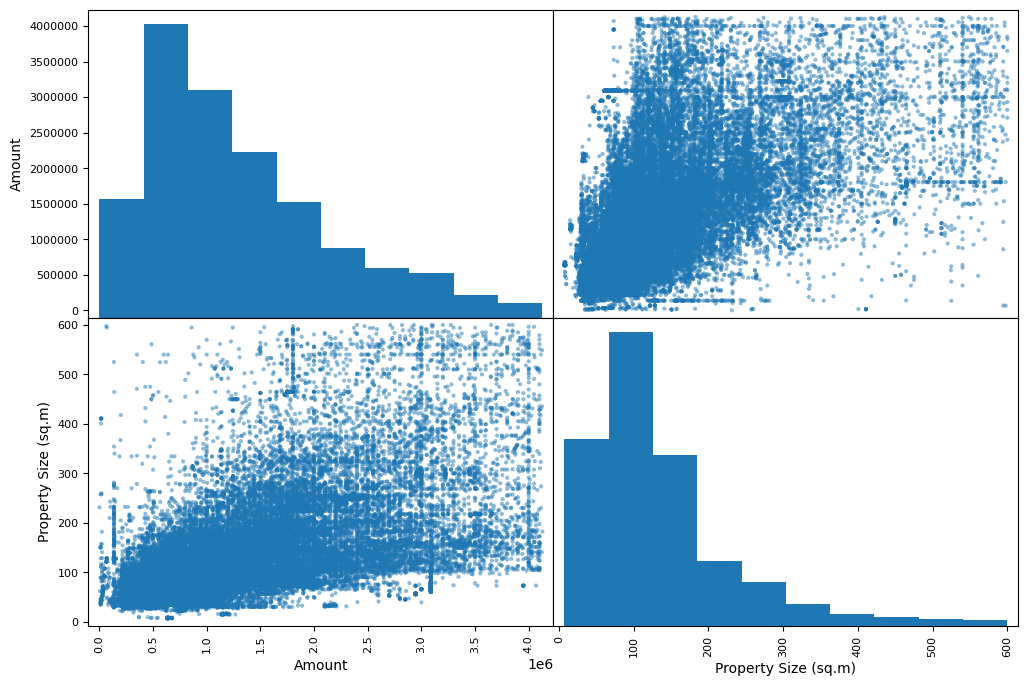

In [203]:
plot_matrix(cleaned_df)

In [204]:
def preparing_data_before_training(data, drop, renameColumns):
    data = data.drop(drop, axis=1)
    data = data.rename(columns=renameColumns)
    return data

In [205]:
prepared_data = preparing_data_before_training(
    cleaned_df, 
    ['date_without_time', 'Transaction Date', 'date'],
    {
        'Property Size (sq.m)': 'Property_Size',
        'Property Sub Type': 'Property_Sub_Type',
        'Nearest Metro': 'Nearest_Metro',
        'Nearest Mall': 'Nearest_Mall',
        'Nearest Landmark': 'Nearest_Landmark',
        'Oil Price': 'Oil_Price',
        'Transaction Type': 'Transaction_Type',
        'length_from_coast': 'Length_From_Coast',
        "Transaction sub type": "Transaction_sub_type",
        "Property Type": "Property_Type",
        "No. of Buyer": 'N_Buyer', 
        "No. of Seller": "N_Seller",
        "Registration type": "Registration_type", 
        "Is Free Hold?": "Is_Free_Hold",
         "Room(s)": 'Rooms'
    }
)


In [206]:
import statsmodels.formula.api as smf

sm_data = sm.add_constant(prepared_data)
first_model = smf.ols(formula='Amount ~ C(Transaction_Type) + C(Usage) + C(Area) + C(Property_Sub_Type) + Property_Size + C(Nearest_Metro) + C(Nearest_Mall) + C(Nearest_Landmark) + N_Buyer + N_Seller + C(Property_Type) + C(Registration_type) + C(Is_Free_Hold) + C(Rooms)', data=sm_data)
first_results = first_model.fit()


In [207]:
first_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Amount   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     785.3
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:57:02   Log-Likelihood:            -7.0121e+05
No. Observations:               48494   AIC:                         1.403e+06
Df Residuals:                   48340   BIC:                         1.404e+06
Df Model:                         153                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                            4.522e+05   8.67e+04      5.216      0.000    2.82e+05    6.22e+05
C(Transaction_Type)[T.Mortgage]                     -1.075e+05   1.14e+04     -9.429      0.000    -1.3e+05   -8.52e+04
C(Transaction_Type)[T.Sales]                         2.565e+05   1.41e+04     18.192      0.000    2.29e+05    2.84e+05
C(Usage)[T.Residential]                             -1.524e+05   4.02e+04     -3.792      0.000   -2.31e+05   -7.36e+04
C(Area)[T.AL BARARI]                                 8.404e+05   6.73e+04     12.484      0.000    7.08e+05    9.72e+05
C(Area)[T.AL FURJAN]                                 4.381e+05   6.65e+04      6.591      0.000    3.08e+05    5.68e+05
C(Area)[T.AL KHAIL HEIGHTS]                         -5.434e+05   1.55e+05     -3.514      0.000   -8.46e+05    -2.4e+05
C(Area)[T.AL WAHA]                                  -2.979e+04   5.97e+04     -0.499      0.618   -1.47e+05    8.72e+04
C(Area)[T.ARABIAN RANCHES I]                         4.256e+05    6.1e+04      6.982      0.000    3.06e+05    5.45e+05
C(Area)[T.ARABIAN RANCHES II]                        4.538e+05   5.96e+04      7.612      0.000    3.37e+05    5.71e+05
C(Area)[T.ARABIAN RANCHES III]                       4.346e+05   7.43e+04      5.846      0.000    2.89e+05     5.8e+05
C(Area)[T.ARJAN]                                       4.2e+05   5.46e+04      7.692      0.000    3.13e+05    5.27e+05
C(Area)[T.Abu Hail]                                 -3.306e+05   2.18e+05     -1.519      0.129   -7.57e+05    9.61e+04
C(Area)[T.Al Bada]                                  -1.609e+06    2.2e+05     -7.306      0.000   -2.04e+06   -1.18e+06
C(Area)[T.Al Baraha]                                 1.118e+06   2.73e+05      4.092      0.000    5.82e+05    1.65e+06
C(Area)[T.Al Barsha First]                           8.622e+05   3.32e+05      2.599      0.009    2.12e+05    1.51e+06
C(Area)[T.Al Barshaa South Third]                     941.6346   2.72e+05      0.003      0.997   -5.32e+05    5.33e+05
C(Area)[T.Al Dhagaya]                                 1.82e+06   3.21e+05      5.674      0.000    1.19e+06    2.45e+06
C(Area)[T.Al Garhoud]                               -9.734e+05   2.91e+05     -3.342      0.001   -1.54e+06   -4.02e+05
C(Area)[T.Al Hamriya]                                1.261e+06   3.21e+05      3.935      0.000    6.33e+05    1.89e+06
C(Area)[T.Al Jafliya]                               -2.254e+06   2.72e+05     -8.276      0.000   -2.79e+06   -1.72e+06
C(Area)[T.Al Karama]                                -1.487e+05   1.94e+05     -0.766      0.444   -5.29e+05    2.32e+05
C(Area)[T.Al Kifaf]                                 -1.417e+05   1.53e+05     -0.92

In [208]:
sm_data = sm.add_constant(prepared_data)
second_model = smf.ols(formula='Amount ~ C(Transaction_Type) + C(Usage) + C(Area) + C(Property_Sub_Type) + Property_Size + C(Nearest_Metro) + C(Nearest_Mall) + C(Nearest_Landmark) + Oil_Price + Length_From_Coast + N_Buyer + N_Seller + C(Property_Type) + C(Registration_type) + C(Is_Free_Hold) + C(Rooms)', data=sm_data)
second_results = second_model.fit()

# formula = 'Amount ~ C(Transaction_Type) + C(Usage) + C(Area) + C(Property_Sub_Type) + Property_Size + C(Nearest_Metro) + C(Nearest_Mall) + C(Nearest_Landmark) + Oil_Price + Length_From_Coast'

In [209]:
second_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Amount   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     788.3
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:57:07   Log-Likelihood:            -7.0103e+05
No. Observations:               48494   AIC:                         1.402e+06
Df Residuals:                   48339   BIC:                         1.404e+06
Df Model:                         154                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                            1.335e+06   1.23e+05     10.878      0.000    1.09e+06    1.57e+06
C(Transaction_Type)[T.Mortgage]                     -1.048e+05   1.14e+04     -9.227      0.000   -1.27e+05   -8.26e+04
C(Transaction_Type)[T.Sales]                         2.607e+05    1.4e+04     18.556      0.000    2.33e+05    2.88e+05
C(Usage)[T.Residential]                             -1.618e+05   4.01e+04     -4.041      0.000    -2.4e+05   -8.33e+04
C(Area)[T.AL BARARI]                                 6.187e+05   5.22e+04     11.850      0.000    5.16e+05    7.21e+05
C(Area)[T.AL FURJAN]                                 2.752e+05   5.35e+04      5.147      0.000     1.7e+05     3.8e+05
C(Area)[T.AL KHAIL HEIGHTS]                         -5.084e+05   1.53e+05     -3.321      0.001   -8.08e+05   -2.08e+05
C(Area)[T.AL WAHA]                                  -1.699e+05   5.99e+04     -2.836      0.005   -2.87e+05   -5.25e+04
C(Area)[T.ARABIAN RANCHES I]                         2.761e+05   5.05e+04      5.471      0.000    1.77e+05    3.75e+05
C(Area)[T.ARABIAN RANCHES II]                          3.1e+05   4.97e+04      6.231      0.000    2.12e+05    4.07e+05
C(Area)[T.ARABIAN RANCHES III]                       2.501e+05    6.5e+04      3.849      0.000    1.23e+05    3.78e+05
C(Area)[T.ARJAN]                                      2.07e+05   4.11e+04      5.039      0.000    1.27e+05    2.88e+05
C(Area)[T.Abu Hail]                                 -4.386e+05   2.14e+05     -2.048      0.041   -8.58e+05   -1.88e+04
C(Area)[T.Al Bada]                                  -1.668e+06   2.21e+05     -7.565      0.000    -2.1e+06   -1.24e+06
C(Area)[T.Al Baraha]                                 1.026e+06    2.7e+05      3.804      0.000    4.97e+05    1.55e+06
C(Area)[T.Al Barsha First]                           5.642e+05   3.24e+05      1.741      0.082   -7.09e+04     1.2e+06
C(Area)[T.Al Barshaa South Third]                   -2.211e+05   2.67e+05     -0.828      0.408   -7.45e+05    3.02e+05
C(Area)[T.Al Dhagaya]                                1.669e+06   3.17e+05      5.260      0.000    1.05e+06    2.29e+06
C(Area)[T.Al Garhoud]                               -9.866e+05   2.89e+05     -3.410      0.001   -1.55e+06    -4.2e+05
C(Area)[T.Al Hamriya]                                1.115e+06   3.17e+05      3.511      0.000    4.92e+05    1.74e+06
C(Area)[T.Al Jafliya]                               -2.321e+06   2.72e+05     -8.528      0.000   -2.85e+06   -1.79e+06
C(Area)[T.Al Karama]                                 -2.43e+05   1.94e+05     -1.255      0.209   -6.23e+05    1.36e+05
C(Area)[T.Al Kifaf]                                  -2.05e+05   1.55e+05     -1.32

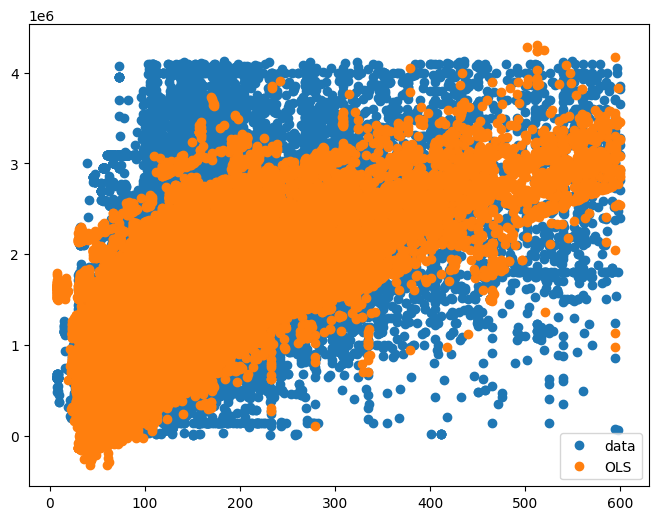

In [210]:
pred_ols = second_results.get_prediction()

fig, ax = plt.subplots(figsize=(8, 6))

x = prepared_data['Property_Size']
y = prepared_data['Amount']

ax.plot(x, y, "o", label="data")
ax.plot(x, second_results.fittedvalues, "o", label="OLS")

ax.legend(loc="best")

In [211]:
prepared_data['Property_Size_Squared'] = prepared_data['Property_Size']**2

In [212]:
sm_data = sm.add_constant(prepared_data)
third_model = smf.ols(formula='Amount ~ C(Transaction_Type) + C(Usage) + C(Area) + C(Property_Sub_Type) + Property_Size + Property_Size_Squared + C(Nearest_Metro) + C(Nearest_Mall) + C(Nearest_Landmark) + Oil_Price + Length_From_Coast + N_Buyer + N_Seller + C(Property_Type) + C(Registration_type) + C(Is_Free_Hold) + C(Rooms)', data=sm_data)
third_results = third_model.fit()

# 'Amount ~ C(Transaction_Type) + C(Usage) + C(Area) + C(Property_Sub_Type) + Property_Size + Property_Size_Squared + C(Nearest_Metro) + C(Nearest_Mall) + C(Nearest_Landmark) + Oil_Price + Length_From_Coast'

In [213]:
third_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Amount   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.722
Method:                 Least Squares   F-statistic:                     814.0
Date:                Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                        02:57:12   Log-Likelihood:            -7.0036e+05
No. Observations:               48494   AIC:                         1.401e+06
Df Residuals:                   48338   BIC:                         1.402e+06
Df Model:                         155                                         
Covariance Type:            nonrobust                                         
=======================================================================================================================
                                                          coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------
Intercept                                            1.275e+06   1.21e+05     10.534      0.000    1.04e+06    1.51e+06
C(Transaction_Type)[T.Mortgage]                     -1.185e+05   1.12e+04    -10.570      0.000    -1.4e+05   -9.65e+04
C(Transaction_Type)[T.Sales]                         2.593e+05   1.39e+04     18.717      0.000    2.32e+05    2.86e+05
C(Usage)[T.Residential]                             -2.926e+05   3.97e+04     -7.378      0.000    -3.7e+05   -2.15e+05
C(Area)[T.AL BARARI]                                 5.095e+05   5.16e+04      9.877      0.000    4.08e+05    6.11e+05
C(Area)[T.AL FURJAN]                                 2.152e+05   5.28e+04      4.079      0.000    1.12e+05    3.19e+05
C(Area)[T.AL KHAIL HEIGHTS]                         -5.426e+05   1.51e+05     -3.594      0.000   -8.39e+05   -2.47e+05
C(Area)[T.AL WAHA]                                  -1.218e+05   5.91e+04     -2.061      0.039   -2.38e+05   -5964.879
C(Area)[T.ARABIAN RANCHES I]                         4.019e+05   4.99e+04      8.054      0.000    3.04e+05       5e+05
C(Area)[T.ARABIAN RANCHES II]                         3.22e+05   4.91e+04      6.562      0.000    2.26e+05    4.18e+05
C(Area)[T.ARABIAN RANCHES III]                           3e+05   6.41e+04      4.678      0.000    1.74e+05    4.26e+05
C(Area)[T.ARJAN]                                     1.638e+05   4.05e+04      4.041      0.000    8.43e+04    2.43e+05
C(Area)[T.Abu Hail]                                 -4.755e+05   2.11e+05     -2.251      0.024   -8.89e+05   -6.15e+04
C(Area)[T.Al Bada]                                  -1.575e+06   2.18e+05     -7.239      0.000      -2e+06   -1.15e+06
C(Area)[T.Al Baraha]                                 9.228e+05   2.66e+05      3.468      0.001    4.01e+05    1.44e+06
C(Area)[T.Al Barsha First]                           5.459e+05    3.2e+05      1.708      0.088   -8.05e+04    1.17e+06
C(Area)[T.Al Barshaa South Third]                   -3.066e+05   2.63e+05     -1.164      0.245   -8.23e+05     2.1e+05
C(Area)[T.Al Dhagaya]                                1.529e+06   3.13e+05      4.886      0.000    9.16e+05    2.14e+06
C(Area)[T.Al Garhoud]                               -7.745e+05   2.85e+05     -2.714      0.007   -1.33e+06   -2.15e+05
C(Area)[T.Al Hamriya]                                9.924e+05   3.13e+05      3.169      0.002    3.79e+05    1.61e+06
C(Area)[T.Al Jafliya]                                -2.35e+06   2.68e+05     -8.757      0.000   -2.88e+06   -1.82e+06
C(Area)[T.Al Karama]                                -5.561e+05   1.91e+05     -2.909      0.004   -9.31e+05   -1.81e+05
C(Area)[T.Al Kifaf]                                 -2.267e+05   1.53e+05     -1.48

## TESTS

In [224]:
ramsey_test_1 = linear_reset(first_results, use_f=True)
ramsey_test_2 = linear_reset(second_results, use_f=True)
ramsey_test_3 = linear_reset(third_results, use_f=True)

In [225]:
reset_ramsey(third_results)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=1078.5733662813618, p=0.0, df_denom=4.83e+04, df_num=4>

In [226]:
# H0 = Model correctly spicified
# H1 = Model misspecified
print(ramsey_test_1)
print(ramsey_test_2)
print(ramsey_test_3)

<F test: F=218356.83387033152, p=0.0, df_denom=4.85e+04, df_num=2>
<F test: F=219720.62579775002, p=0.0, df_denom=4.85e+04, df_num=2>
<F test: F=115842.85198367301, p=0.0, df_denom=4.85e+04, df_num=2>


In [216]:
prepared_data_four = prepared_data
prepared_data_four['Price_per_sqm'] = prepared_data_four['Amount'] / prepared_data_four['Property_Size']
sm_data_four = sm.add_constant(prepared_data)

# 'Price_per_sqm ~ C(Transaction_Type) + C(Usage) + C(Area) + C(Property_Sub_Type) + C(Nearest_Metro) + C(Nearest_Mall) + C(Nearest_Landmark) + Oil_Price + Length_From_Coast'

four_model_formula = 'np.log(Price_per_sqm) ~ C(Usage) + C(Area) + C(Property_Sub_Type) + Oil_Price + Length_From_Coast'

four_model = smf.ols(formula=four_model_formula, data=sm_data_four)

four_results = four_model.fit()

In [217]:
four_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(Price_per_sqm)   R-squared:                       0.489
Model:                               OLS   Adj. R-squared:                  0.487
Method:                    Least Squares   F-statistic:                     364.1
Date:                   Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                           02:57:18   Log-Likelihood:                -28819.
No. Observations:                  48494   AIC:                         5.789e+04
Df Residuals:                      48366   BIC:                         5.902e+04
Df Model:                            127                                         
Covariance Type:               nonrobust                                         
==============================================================================================================
                                                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      7.7451      0.060    128.998      0.000       7.627       7.863
C(Usage)[T.Residential]                        0.0886      0.022      3.955      0.000       0.045       0.132
C(Area)[T.AL BARARI]                           0.4525      0.027     16.885      0.000       0.400       0.505
C(Area)[T.AL FURJAN]                           0.1583      0.019      8.198      0.000       0.120       0.196
C(Area)[T.AL KHAIL HEIGHTS]                   -0.6051      0.035    -17.186      0.000      -0.674      -0.536
C(Area)[T.AL WAHA]                            -0.4922      0.055     -8.998      0.000      -0.599      -0.385
C(Area)[T.ARABIAN RANCHES I]                  -0.1210      0.028     -4.325      0.000      -0.176      -0.066
C(Area)[T.ARABIAN RANCHES II]                  0.1793      0.029      6.174      0.000       0.122       0.236
C(Area)[T.ARABIAN RANCHES III]                 0.3453      0.026     13.502      0.000       0.295       0.395
C(Area)[T.ARJAN]                               0.1917      0.019      9.978      0.000       0.154       0.229
C(Area)[T.Abu Hail]                           -0.7229      0.113     -6.375      0.000      -0.945      -0.501
C(Area)[T.Al Bada]                            -0.4072      0.155     -2.635      0.008      -0.710      -0.104
C(Area)[T.Al Baraha]                           0.8200      0.194      4.219      0.000       0.439       1.201
C(Area)[T.Al Barsha First]                     0.6387      0.309      2.066      0.039       0.033       1.245
C(Area)[T.Al Barshaa South Third]             -0.4911      0.253     -1.940      0.052      -0.987       0.005
C(Area)[T.Al Dhagaya]                          1.4871      0.251      5.929      0.000       0.995       1.979
C(Area)[T.Al Garhoud]                         -0.4115      0.218     -1.889      0.059      -0.838       0.015
C(Area)[T.Al Hamriya]                          0.5602      0.251      2.231      0.026       0.068       1.052
C(Area)[T.Al Jafliya]                         -1.2551      0.218     -5.767      0.000      -1.682      -0.829
C(Area)[T.Al Karama]                           0.2716      0.179      1.521      0.128      -0.079       0.622
C(Area)[T.Al Kifaf]                            0.4703      0.032     14.602      0.000       0.407       0.533
C(Area)[T.Al Muteena]                          0.2222      0.114      1.950      0.051      -0.001       0.446
C(Area)[T.Al Qusais Industrial Fourth]         0.6335      0.047     13.407      0.000       0.541       0.726
C(Area)[T.Al Qusais Second]                   -0.8391      0.434     -1.931      0.053      -1.691       0.012
C(Area)[T.Al Qusais Third]                    -1.6713

In [218]:
ramsey_test_4 = linear_reset(four_results)

/Users/germanignatovich/Desktop/projects/hse/econometrics-project-assignment-hse-2022/venv/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


In [219]:
ramsey_test_4

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=158.52696588167146, p-value=3.769699590079327e-35, df_denom=2>

In [93]:
four_results_robust_HC0 = four_model.fit(cov_type='HC0')

In [94]:
four_results_robust_HC0.summary()

/Users/germanignatovich/Desktop/projects/hse/econometrics-project-assignment-hse-2022/venv/lib/python3.8/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 149, but rank is 142
  warnings.warn('covariance of constraints does not have full '


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(Price_per_sqm)   R-squared:                       0.509
Model:                               OLS   Adj. R-squared:                  0.507
Method:                    Least Squares   F-statistic:                     1752.
Date:                   Tue, 14 Mar 2023   Prob (F-statistic):               0.00
Time:                           02:42:55   Log-Likelihood:                -33004.
No. Observations:                  52655   AIC:                         6.630e+04
Df Residuals:                      52507   BIC:                         6.762e+04
Df Model:                            147                                         
Covariance Type:                     HC0                                         
==============================================================================================================
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
Intercept                                      7.3253      0.062    119.080      0.000       7.205       7.446
C(Usage)[T.Residential]                        0.1603      0.019      8.249      0.000       0.122       0.198
C(Area)[T.AL BARARI]                           0.3696      0.024     15.217      0.000       0.322       0.417
C(Area)[T.AL FURJAN]                          -0.0207      0.020     -1.051      0.293      -0.059       0.018
C(Area)[T.AL KHAIL HEIGHTS]                   -0.6126      0.035    -17.326      0.000      -0.682      -0.543
C(Area)[T.AL WAHA]                            -0.5463      0.029    -19.088      0.000      -0.602      -0.490
C(Area)[T.ARABIAN RANCHES I]                  -0.1035      0.016     -6.485      0.000      -0.135      -0.072
C(Area)[T.ARABIAN RANCHES II]                  0.1165      0.023      5.149      0.000       0.072       0.161
C(Area)[T.ARABIAN RANCHES III]                 0.3255      0.016     20.480      0.000       0.294       0.357
C(Area)[T.ARJAN]                               0.1356      0.019      7.219      0.000       0.099       0.172
C(Area)[T.Abu Hail]                           -0.5570      0.457     -1.220      0.223      -1.452       0.338
C(Area)[T.Al Bada]                             0.3298      0.303      1.089      0.276      -0.264       0.923
C(Area)[T.Al Baraha]                           1.3076      0.194      6.755      0.000       0.928       1.687
C(Area)[T.Al Barsha First]                     0.1372      0.391      0.351      0.726      -0.629       0.903
C(Area)[T.Al Barsha Third]                    -0.5489      0.039    -13.947      0.000      -0.626      -0.472
C(Area)[T.Al Barshaa South First]             -1.3399      0.343     -3.909      0.000      -2.012      -0.668
C(Area)[T.Al Barshaa South Third]             -0.5474      0.075     -7.276      0.000      -0.695      -0.400
C(Area)[T.Al Dhagaya]                          1.6913      0.086     19.737      0.000       1.523       1.859
C(Area)[T.Al Garhoud]                         -0.1123      0.112     -1.001      0.317      -0.332       0.107
C(Area)[T.Al Hamriya]                          0.8326      0.273      3.054      0.002       0.298       1.367
C(Area)[T.Al Jafliya]                         -0.1946      0.428     -0.454      0.650      -1.034       0.645
C(Area)[T.Al Karama]                           0.7923      0.260      3.042      0.002       0.282       1.303
C(Area)[T.Al Kifaf]                            0.4979      0.028     17.977      0.000       0.444       0.552
C(Area)[T.Al Manara]                          -0.6402      0.016    -40.530      0.000      -0.671      -0.609
C(Area)[T.Al Mezhar First]                    -0.9829

In [95]:
ramsey_test_4_robust_HC0 = linear_reset(four_results_robust_HC0)

/Users/germanignatovich/Desktop/projects/hse/econometrics-project-assignment-hse-2022/venv/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:1081: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  aug = res.fittedvalues[:, None]


In [96]:
ramsey_test_4_robust_HC0

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=144.04439783780208, p-value=5.262067744951759e-32, df_denom=2>

In [97]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def VIF2(model, results):  # from model
    """
    Calculates VIF coefficients for given model. Returns DataFrame.
    
    Arguments:
    model - fitted regression model from Statsmodels
    
    Interpretation:
    The variance inflation factor is a measure for the increase of the variance of the parameter estimates 
    if an additional variable, given by exog_idx is added to the linear regression. 
    It is a measure for multicollinearity of the design matrix, exog.

    One recommendation is that if VIF is greater than 5, 
    then the explanatory variable given by exog_idx is highly collinear with the other explanatory variables,
    and the parameter estimates will have large standard errors because of this.
        
    Sources:
    https://en.wikipedia.org/wiki/Variance_inflation_factor
    https://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.variance_inflation_factor.html
    
    """
    vif_data = pd.DataFrame()
    vif_data["feature"] = model.exog_names

    vif_values = []
    for i in range(len(model.exog_names)):
        vif_values.append(variance_inflation_factor(results.model.exog, i))

    vif_data['VIF'] = vif_values
    return vif_data

In [98]:
VIF_4 = VIF2(four_model, four_results)

/Users/germanignatovich/Desktop/projects/hse/econometrics-project-assignment-hse-2022/venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/germanignatovich/Desktop/projects/hse/econometrics-project-assignment-hse-2022/venv/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [99]:
VIF_4 = VIF2(four_model, four_results_robust_HC0)

/Users/germanignatovich/Desktop/projects/hse/econometrics-project-assignment-hse-2022/venv/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/germanignatovich/Desktop/projects/hse/econometrics-project-assignment-hse-2022/venv/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


KeyboardInterrupt: 